# 2 Linear Regression - cross validation (Python)

## 2.1 Utility Functions
Rewrite the code in the previous tutorial as functions, and expand them to *deg* degree with *deg+1* terms. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# functions based on the previous section
def polynomial_basis(x, deg):
    X = np.power(np.reshape(x,[-1,1]), np.linspace(deg,0,deg+1))
    return X

def polynomial_fit(x, t, deg):
    X = polynomial_basis(x, deg)
    w = np.linalg.lstsq(X, t, rcond=None)
    return w[0]


def polynomial_evaluate(x, w):
    X = polynomial_basis(x, w.size-1)
    t = np.matmul(X, w)
    return t

def rms_error(residuals):
    return np.sqrt(np.mean(np.square(residuals)))

# test
X = polynomial_basis(np.array([.1,.2,.3,.4,.5]), 3)
print(X)

[[0.001 0.01  0.1   1.   ]
 [0.008 0.04  0.2   1.   ]
 [0.027 0.09  0.3   1.   ]
 [0.064 0.16  0.4   1.   ]
 [0.125 0.25  0.5   1.   ]]


## 2.2 Data
The true model here is a polynomial with degree of 4:

\begin{equation}
t = w_3x^3 + w_2x^2 + w_1x +w_0
\end{equation}

with weights $$\textbf{w}=\begin{vmatrix}4 & 3 & 2 & 1\end{vmatrix}^T$$


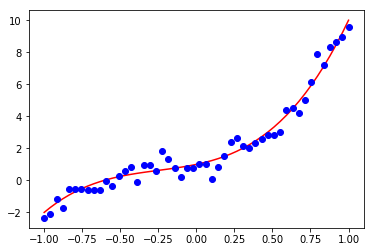

In [2]:
# model
w = np.reshape([4, 3, 2, 1], [-1, 1])

# sample locations
n = 50
x = np.linspace(-1,1,n)

# observed target data
std_noise = 0.5
t = polynomial_evaluate(x, w)
t_observed = t + np.random.normal(0,std_noise,[n,1])

# plot
plt.plot(x,t,'r')
plt.plot(x,t_observed,'bo')

# holdout (also observed) data
n_holdout = 30
x_holdout = np.linspace(-1,1,n_holdout)
t_holdout = polynomial_evaluate(x_holdout, w) + np.random.normal(0,std_noise,[n_holdout,1])

## 2.3 Underfitting and Overfitting
Test the following polynomial models, the first of which is a straight line:

\begin{equation}
t_{deg=1} = w_1x + w_0
\end{equation}

\begin{equation}
t_{deg=2} = w_2x^2 + w_1x + w_0
\end{equation}

\begin{equation}
t_{deg=3} = w_3x^3 + w_2x^2 + w_1x + w_0
\end{equation}

$$\cdots$$

\begin{equation}
t_{deg=m} = w_mx^m + \cdots + w_3x^3 + w_2x^2 + w_1x + w_0
\end{equation}

[1, 77.5171973738, 1.2451280847671857]
[2, 36.38297186017745, 0.8530295640852953]
[3, 11.322059819580106, 0.47585837850310264]
[4, 11.307122526402111, 0.4755443728276492]
[5, 10.830949298587125, 0.4654234480252821]
[10, 7.703613187450802, 0.3925203991501793]
[20, 5.723462562446659, 0.3383330478226051]
[30, 2.2215094034157694, 0.2107846960011931]


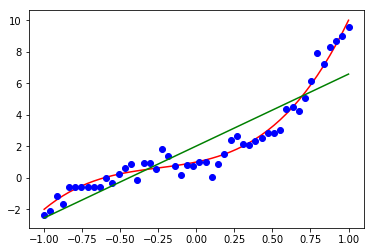

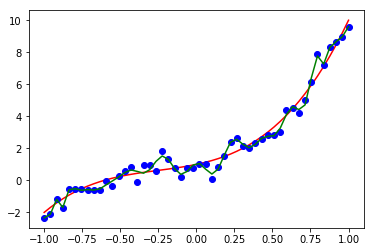

In [3]:
# first, fit the polynomials
degrees = [1,2,3,4,5,10,20,30]  # examples of degrees
w_estimates = []
t_estimates = []
for idx in range(len(degrees)):
    w_estimates.append(polynomial_fit(x, t_observed, deg=degrees[idx]))
    t_estimates.append(polynomial_evaluate(x, w_estimates[idx]))
    
    # residuals and root-mean-square errors
    Residuals = t_estimates[idx]-t_observed
    SR = np.sum(np.square(Residuals))
    RMSE = rms_error(Residuals)
    print([degrees[idx],SR,RMSE])

# now plot each fitted curve to compare, for example:
plt.figure()
idx = degrees.index(1)
plt.plot(x,t,'r')
plt.plot(x,t_observed,'bo')
plt.plot(x,t_estimates[idx],'g')

plt.figure()
idx = degrees.index(30)
plt.plot(x,t,'r')
plt.plot(x,t_observed,'bo')
plt.plot(x,t_estimates[idx],'g')

## 2.3 k-fold Cross-validation
(From Wikipedia) In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling (see below) is that all observations are used for both training and validation, and each observation is used for validation exactly once.

In [4]:
import random

# shuffle data first
indices = [idx for idx in range(n)]
random.seed(1)
random.shuffle(indices)

# set up a 5-fold cross-validation
k = 5
size_fold = int(n/k)
deg = 4  # model to fit

Residuals_train = []
Residuals_test = []
for idx_fold in range(k):  # fold index
    # set indices for training data and test data
    indices_test = indices[idx_fold*size_fold:(idx_fold+1)*size_fold]
    indices_train = list(set(indices) - set(indices_test))
    
    # training    
    w_train = polynomial_fit(x[indices_train], t_observed[indices_train], deg=deg)
    t_train = polynomial_evaluate(x[indices_train], w_train)    
    Residuals_train.append(t_train-t_observed[indices_train])
    # testing
    t_test = polynomial_evaluate(x[indices_test], w_train)
    Residuals_test.append(t_test-t_observed[indices_test])

# calculating training and testing errors
RMSE_train = rms_error(np.concatenate(Residuals_train, axis=0))
RMSE_test = rms_error(np.concatenate(Residuals_test, axis=0))
print(RMSE_train) 
print(RMSE_test)

0.4693891791110898
0.537385282410005


## Question
- Find an optimal degree with respect to the testing error.

## 2.4 Generalisability
This is quantified by the test-error on holdout data

In [14]:
# build the model using all the data and the optimised hyperparameter degree
deg = 4
w_train = polynomial_fit(x, t_observed, deg=deg)
t_train = polynomial_evaluate(x, w_train)
RMSE_train = rms_error(t_train-t_observed)
t_test = polynomial_evaluate(x_holdout, w_train)
RMSE_test = rms_error(t_test-t_holdout)
print(RMSE_train) 
print(RMSE_test)

0.4755443728276492
0.6365573793232249


## Questions
- Adding norm-2 regularisation
- Required data size for training and testing
- Compare testing errors in cross-validation and those based on holdout data